In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
from analysis.analysis import *
import analysis.classifier as classifier

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")
#q1.ge_amp =0.2

Qubit(ef_time=76.411, ge_ssm=-0.11, ro_amp=0.6, qubit_thr=[-10000, -600], RO_LO_pwr=16, RO_LO=6.6247, ge_amp=1.2, IQ_angle=205, ROq3=6.583064, ge_time=52.17178532987394, ef_amp=1, ROIF=0.10280000000000022, RO_IF=0.030850000000000044, ef_ssm=-0.255, qubit_id=q1, ro_freq=6.7275, ro_dur=4000)
Qubit(ef_time=None, ge_ssm=-0.152, ro_amp=0.4, qubit_thr=[-10000, 1900], RO_LO_pwr=16, RO_LO=6.6247, ge_amp=1.2, IQ_angle=85, ROq3=6.583064, ge_time=40.15374412400174, ef_amp=1, ROIF=0.030850000000000044, RO_IF=0.10280000000000022, ef_ssm=-0.224, qubit_id=q2, ro_freq=6.65555, ro_dur=4000)


In [4]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [5]:
def run_rabi(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.992054 sec
Captured 17 buffers (2.431332 buffers per sec)
Captured 52224 records (7469.050392 records per sec)
Transferred 855638016 bytes (122372921.621408 bytes per sec)


<Figure size 800x800 with 0 Axes>

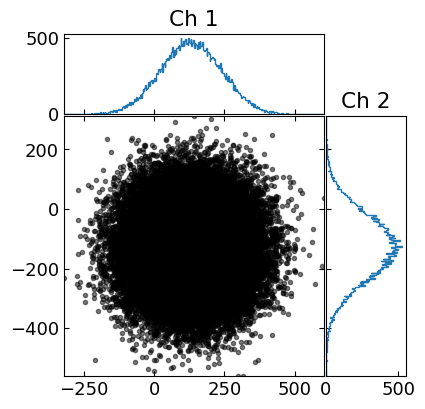

<Figure size 800x800 with 0 Axes>

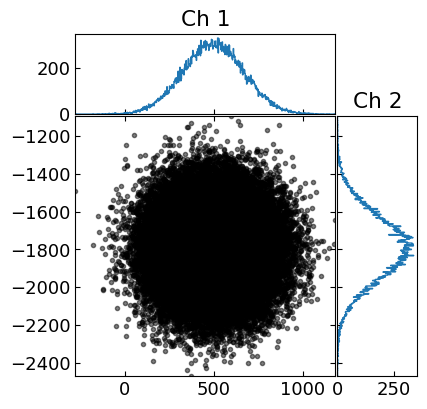

In [7]:
num_steps = 101
reps = 500
sweep_time=200
values , IQ_df= run_rabi(q1, q2, general_vals_dict,num_steps, sweep_time,reps)

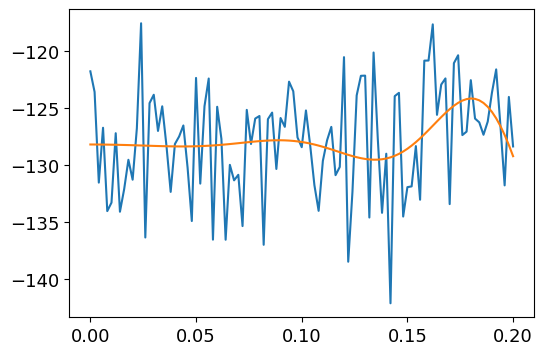



  freq: 10.968199845836772 +/- 2.196872168678222
 gamma: -25.146363009396595 +/- 20.030928262117197
   amp: 0.04665684538756357 +/- 0.16025023508418446
 phase: -241.75629681538928 +/- 147.23204969869929
offset: -128.24022105976724 +/- 0.5244458519576426
pi_pulse time: 0.04558633203513212 +/- 2.196872168678222
π_ge time = 45.586332035132116 ns


In [8]:
which_qubit = 1
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    


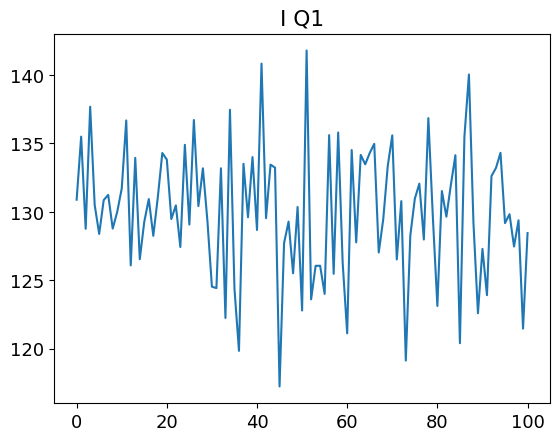

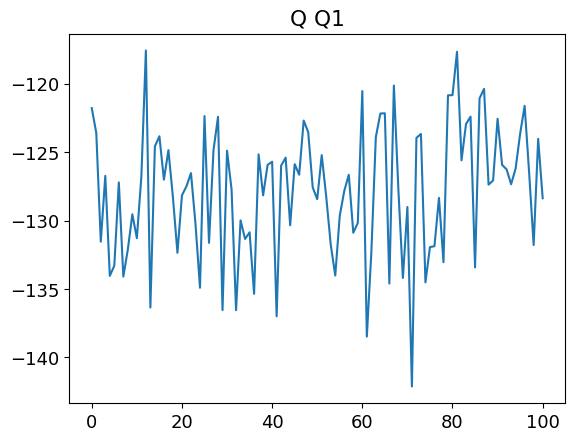

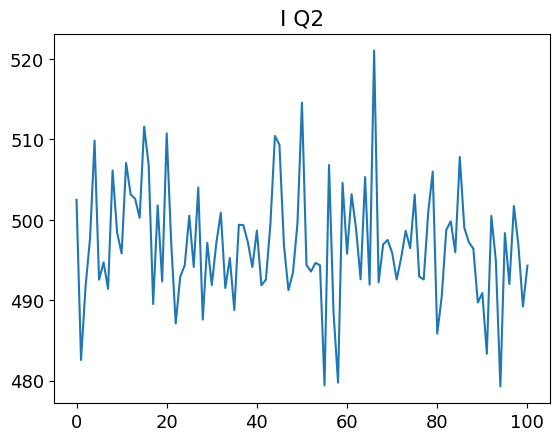

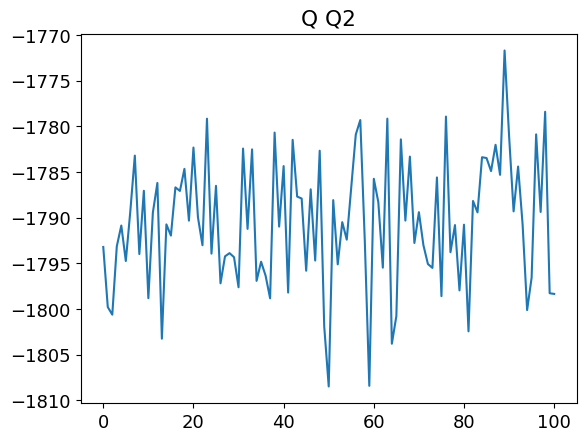

In [9]:
plt.plot(I_Q1);plt.title('I Q1');plt.show()
plt.plot(Q_Q1);plt.title('Q Q1');plt.show()

plt.plot(values.rec_avg_vs_pats_2[0]);plt.title('I Q2');plt.show()
plt.plot(values.rec_avg_vs_pats_2[1]);plt.title('Q Q2');plt.show()

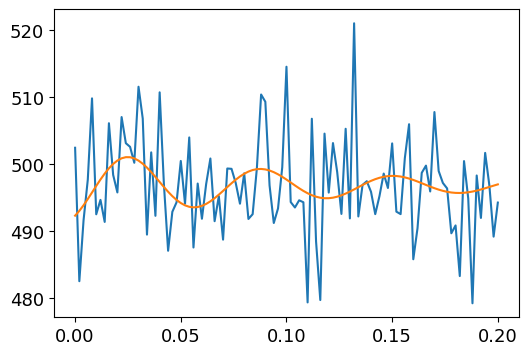



  freq: 15.95678874341948 +/- 1.2473716800673937
 gamma: 8.601153569461808 +/- 8.544889579860998
   amp: 5.297096694114928 +/- 3.169674448346257
 phase: -58.01747100345187 +/- 30.0694780736195
offset: 496.84047565561946 +/- 0.7378234840283773
pi_pulse time: 0.03133462553398773 +/- 1.2473716800673937
π_ge time = 31.334625533987726 ns


In [10]:
which_qubit = 2
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    